# Multivariate Time Series forecast using seq2seq in TensorFlow

This notebook implements the cast study of applying seq2seq model for time series data. 

The purpose is to showcase the effectiveness of seq2seq to learn the true patterns under the noisy signals. In addition, we are able to implement models with flexibility such as: 

- Variable input and output sequence lengths
- Variable numbers of input and output signals 

This tutorial is divided into four parts - first we will be demonstrating how to train a basicseq2seq model on univariate data. The model is then easily applied to multivariate cases. We will then discuss about situation with outliers. And finally, we will showcase a real-world dataset to forecast pollution (pm2.5) in Beijing. 

To see the comprehensive explanations of each step, can jump to the post associated with this study - 
weiminwang.blog/2017/09/29/multivariate-time-series-forecast-using-seq2seq-in-tensorflow/

This is a long notebook - you can choose the session of your interests by clicking on the links below: 

## Contents

### 1) <b>[Univariate time series](#session1)</b> 

### 2) <b>[Multivariate time series](#session2)</b> 

### 3) <b>[Seq2seq for outliers/extreme events](#session3)</b> 

### 4) <b>[A case study - Beijing pollution data](#session4)</b> 
data credits go to UCI - https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

<a id='session1'></a>
# Univariate time series

In [8]:
import tensorflow as tf
import numpy as np 
import random
import math
from matplotlib import pyplot as plt
import os
import copy
import warnings; warnings.filterwarnings('ignore')
from tensorflow.python.client import device_lib

In [9]:
def get_available_gpus():
    local_devices = device_lib.list_local_devices()
    return [x for x in local_devices if x.device_type == 'GPU']

In [10]:
get_available_gpus()

[name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 235929600
 locality {
   bus_id: 1
 }
 incarnation: 16517656990859586270
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

<a id='session4'></a>
# Real-world case - Beijing PM2.5 Data Set

This data set can be downloaded from UCI website - https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

The remaining session will use this dataset as an example to demonstrate on how to apply seq2seq model to solve a real world problem



## Data exploration

   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0


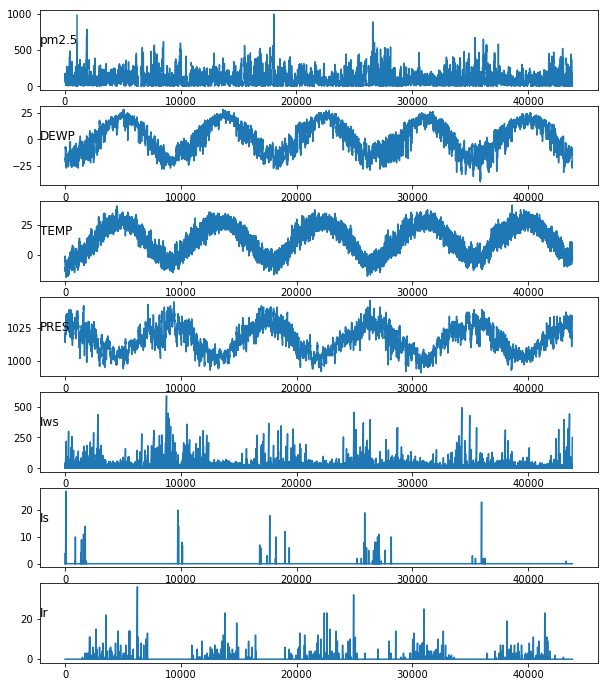

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

df = pd.read_csv('./PRSA_data_2010.1.1-2014.12.31.csv')
print(df.head())

cols_to_plot = ["pm2.5", "DEWP", "TEMP", "PRES", "Iws", "Is", "Ir"]
i = 1
# plot each column
plt.figure(figsize = (10,12))
for col in cols_to_plot:
    plt.subplot(len(cols_to_plot), 1, i)
    plt.plot(df[col])
    plt.title(col, y=0.5, loc='left')
    i += 1
plt.show()

## Preprocessing - there are many other ways

In [3]:
## Fill NA with 0 
#print(df.isnull().sum())
df.fillna(0, inplace = True)

## One-hot encode 'cbwd'
temp = pd.get_dummies(df['cbwd'], prefix='cbwd')
df = pd.concat([df, temp], axis = 1)
del df['cbwd'], temp

## Split into train and test - I used the last 1 month data as test, but it's up to you to decide the ratio
#df_train = df.iloc[:(-31*24), :].copy()
#df_test = df.iloc[-31*24:, :].copy()
train_size = 365 * 24 * 4
df_train = df.iloc[:(train_size), :].copy()
df_test = df.iloc[train_size:, :].copy()

## take out the useful columns for modeling - you may also keep 'hour', 'day' or 'month' and to see if that will improve your accuracy
X_train = df_train.loc[:, ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']].values.copy()
X_test = df_test.loc[:, ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']].values.copy()
y_train = df_train['pm2.5'].values.copy().reshape(-1, 1)
y_test = df_test['pm2.5'].values.copy().reshape(-1, 1)

## z-score transform x - not including those one-hot columns!
for i in range(X_train.shape[1]-4):
    temp_mean = X_train[:, i].mean()
    temp_std = X_train[:, i].std()
    X_train[:, i] = (X_train[:, i] - temp_mean) / temp_std
    X_test[:, i] = (X_test[:, i] - temp_mean) / temp_std
    
## z-score transform y
y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

## Prepare training and test datasets in 3-D format - (batch_size, time_step, feature_dim)

In [4]:
input_seq_len = 30
output_seq_len = 5

# previous batch size was 10
def generate_train_samples(x = X_train, y = y_train, batch_size = 10, input_seq_len = input_seq_len, output_seq_len = output_seq_len):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size, replace = False)
    
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
    
    return input_seq, output_seq # in shape: (batch_size, time_steps, feature_dim)

def generate_test_samples(x = X_test, y = y_test, input_seq_len = input_seq_len, output_seq_len = output_seq_len):
    
    total_samples = x.shape[0]
    
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
    
    return input_seq, output_seq

In [5]:
x, y = generate_train_samples()
print(x.shape, y.shape)

(10, 30, 11) (10, 5, 1)


In [6]:
test_x, test_y = generate_test_samples()
print(test_x.shape, test_y.shape)

(8749, 30, 11) (8749, 5, 1)


## Using this input struct to build Keras Seq2Seq

In [7]:
import seq2seq
from seq2seq.models import Seq2Seq, SimpleSeq2Seq

#model = Seq2Seq(batch_input_shape=x.shape, hidden_dim=10, output_length=8, output_dim=20, depth=4)
# model = Seq2Seq(batch_input_shape=x.shape, output_dim=8, output_length=5)
# model.compile(loss='mse', optimizer='rmsprop')

ModuleNotFoundError: No module named 'seq2seq'

In [49]:
model = Seq2Seq(batch_input_shape=(None, 30, 11), hidden_dim=10, output_length=5, output_dim=1, depth=3)
model.compile(loss='mse', optimizer='rmsprop')

In [50]:
model

In [51]:
test_x.shape

(8749, 30, 11)

In [52]:
test_preds = model.predict(test_x)

In [131]:
test_preds.shape

(8749, 5, 1)

In [53]:
test_y.shape

(8749, 5, 1)

In [54]:
print("Test mse is: ", np.mean((test_preds - test_y)**2))

Test mse is:  1.03805731685


In [55]:
rmse = np.sqrt(1.0381)

In [56]:
rmse

1.0188719252192593

In [ ]:
dim1, dim2 = test_preds.shape[0], test_preds.shape[1]
yhat_inv = test_preds.reshape(dim1*dim2, 1)
y_inv = test_y.reshape(dim1*dim2, 1)

In [60]:
plot_test(yhat_inv[:31*24*2,], test_y_expand[:31*24*2,])

NameError: name 'test_y_expand' is not defined

## Building the model - same multi-variate graph

In [8]:
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes
import tensorflow as tf
import copy
import os

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = input_seq_len
# length of output signals
output_seq_len = output_seq_len
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = X_train.shape[1]
# num of output signals
output_dim = y_train.shape[1]
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

def build_graph(feed_previous = False):
    
    tf.reset_default_graph()
    
    global_step = tf.Variable(
                  initial_value=0,
                  name="global_step",
                  trainable=False,
                  collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])
    
    weights = {
        'out': tf.get_variable('Weights_out', \
                               shape = [hidden_dim, output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.truncated_normal_initializer()),
    }
    biases = {
        'out': tf.get_variable('Biases_out', \
                               shape = [output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.constant_initializer(0.)),
    }
                                          
    with tf.variable_scope('Seq2seq'):
        # Encoder: inputs
        enc_inp = [
            tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
               for t in range(input_seq_len)
        ]

        # Decoder: target outputs
        target_seq = [
            tf.placeholder(tf.float32, shape=(None, output_dim), name="y".format(t))
              for t in range(output_seq_len)
        ]

        # Give a "GO" token to the decoder. 
        # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the 
        # first element will be fed as decoder input which is then 'un-guided'
        dec_inp = [ tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO") ] + target_seq[:-1]

        with tf.variable_scope('LSTMCell'): 
            cells = []
            for i in range(num_stacked_layers):
                with tf.variable_scope('RNN_{}'.format(i)):
                    cells.append(tf.contrib.rnn.LSTMCell(hidden_dim))
            cell = tf.contrib.rnn.MultiRNNCell(cells)
         
        def _rnn_decoder(decoder_inputs,
                        initial_state,
                        cell,
                        loop_function=None,
                        scope=None):
          """RNN decoder for the sequence-to-sequence model.
          Args:
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            initial_state: 2D Tensor with shape [batch_size x cell.state_size].
            cell: rnn_cell.RNNCell defining the cell function and size.
            loop_function: If not None, this function will be applied to the i-th output
              in order to generate the i+1-st input, and decoder_inputs will be ignored,
              except for the first element ("GO" symbol). This can be used for decoding,
              but also for training to emulate http://arxiv.org/abs/1506.03099.
              Signature -- loop_function(prev, i) = next
                * prev is a 2D Tensor of shape [batch_size x output_size],
                * i is an integer, the step number (when advanced control is needed),
                * next is a 2D Tensor of shape [batch_size x input_size].
            scope: VariableScope for the created subgraph; defaults to "rnn_decoder".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing generated outputs.
              state: The state of each cell at the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
                (Note that in some cases, like basic RNN cell or GRU cell, outputs and
                 states can be the same. They are different for LSTM cells though.)
          """
          with variable_scope.variable_scope(scope or "rnn_decoder"):
            state = initial_state
            outputs = []
            prev = None
            for i, inp in enumerate(decoder_inputs):
              if loop_function is not None and prev is not None:
                with variable_scope.variable_scope("loop_function", reuse=True):
                  inp = loop_function(prev, i)
              if i > 0:
                variable_scope.get_variable_scope().reuse_variables()
              output, state = cell(inp, state)
              outputs.append(output)
              if loop_function is not None:
                prev = output
          return outputs, state

        def _basic_rnn_seq2seq(encoder_inputs,
                              decoder_inputs,
                              cell,
                              feed_previous,
                              dtype=dtypes.float32,
                              scope=None):
          """Basic RNN sequence-to-sequence model.
          This model first runs an RNN to encode encoder_inputs into a state vector,
          then runs decoder, initialized with the last encoder state, on decoder_inputs.
          Encoder and decoder use the same RNN cell type, but don't share parameters.
          Args:
            encoder_inputs: A list of 2D Tensors [batch_size x input_size].
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            feed_previous: Boolean; if True, only the first of decoder_inputs will be
              used (the "GO" symbol), all other inputs will be generated by the previous 
              decoder output using _loop_function below. If False, decoder_inputs are used 
              as given (the standard decoder case).
            dtype: The dtype of the initial state of the RNN cell (default: tf.float32).
            scope: VariableScope for the created subgraph; default: "basic_rnn_seq2seq".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing the generated outputs.
              state: The state of each decoder cell in the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
          """
          with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
            enc_cell = copy.deepcopy(cell)
            _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
            if feed_previous:
                return _rnn_decoder(decoder_inputs, enc_state, cell, _loop_function)
            else:
                return _rnn_decoder(decoder_inputs, enc_state, cell)

        def _loop_function(prev, _):
          '''Naive implementation of loop function for _rnn_decoder. Transform prev from 
          dimension [batch_size x hidden_dim] to [batch_size x output_dim], which will be
          used as decoder input of next time step '''
          return tf.matmul(prev, weights['out']) + biases['out']
        
        dec_outputs, dec_memory = _basic_rnn_seq2seq(
            enc_inp, 
            dec_inp, 
            cell, 
            feed_previous = feed_previous
        )

        reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]
        
    # Training loss and optimizer
    with tf.variable_scope('Loss'):
        # L2 loss
        output_loss = 0
        for _y, _Y in zip(reshaped_outputs, target_seq):
            output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

        # L2 regularization for weights and biases
        reg_loss = 0
        for tf_var in tf.trainable_variables():
            if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

        loss = output_loss + lambda_l2_reg * reg_loss

    with tf.variable_scope('Optimizer'):
        optimizer = tf.contrib.layers.optimize_loss(
                loss=loss,
                learning_rate=learning_rate,
                global_step=global_step,
                optimizer='Adam',
                clip_gradients=GRADIENT_CLIPPING)
        
    saver = tf.train.Saver
    
    return dict(
        enc_inp = enc_inp, 
        target_seq = target_seq, 
        train_op = optimizer, 
        loss=loss,
        saver = saver, 
        reshaped_outputs = reshaped_outputs,
        )

## Train the model 

In [9]:
import time

In [10]:
start = time.time()

In [11]:
total_iteractions = 100
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 40, 130)
train_data_x = x[:110]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'multivariate_ts_pollution_case'))
        
print("Checkpoint saved at: ", save_path)
print('Time taken to train: ', time.time() - start)

Training losses: 
7.37395
51.9644
22.581
4.07167
6.55962
4.41925
8.32124
1.23114
6.12579
10.5428
2.00632
0.908997
0.696232
2.80358
1.52206
1.29734
0.690599
0.508793
0.802822
0.862631
1.1344
0.865122
0.74359
0.692543
0.703338
0.552535
0.429473
0.430591
3.81669
0.465068
1.20684
0.488705
0.432281
0.650251
0.399308
0.557235
0.740858
0.787022
0.410585
0.98548
0.49952
0.51285
0.499004
0.283715
0.470236
0.717096
0.951811
0.201008
0.678444
0.388751
0.475002
1.32163
0.833317
0.913159
0.776448
0.495794
0.241492
2.18188
0.455612
0.34322
1.23324
0.296736
0.607495
0.403475
0.454951
0.653456
0.406169
0.271278
0.296302
5.76896
2.47302
0.452914
0.704037
0.559672
0.530383
0.653308
0.299134
0.61683
0.503331
0.245602
0.441918
0.66818
0.872848
1.6696
0.654785
0.772837
0.280974
0.89331
0.365053
0.278666
0.648525
0.613169
0.283347
0.514679
0.59853
0.337565
0.398784
0.264544
0.436283
0.502844
Checkpoint saved at:  ./multivariate_ts_pollution_case
Time taken to train:  37.53213620185852


## Inference on test 
Notice the batch prediction which is different to previous

In [12]:
start_test = time.time()
rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess,  os.path.join('./', 'multivariate_ts_pollution_case'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_x[:, t, :] for t in range(input_seq_len)} # batch prediction
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([test_x.shape[0], output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = [np.expand_dims(pred, 1) for pred in final_preds]
    final_preds = np.concatenate(final_preds, axis = 1)
    print("Test mse is: ", np.mean((final_preds - test_y)**2))

INFO:tensorflow:Restoring parameters from ./multivariate_ts_pollution_case
Test mse is:  0.236698968576


In [13]:
end_test = time.time()
print('Time to test is: ', end_test - start_test)

Time to test is:  13.171932458877563


In [14]:
## remove duplicate hours and concatenate into one long array
test_y_expand = np.concatenate([test_y[i].reshape(-1) for i in range(0, test_y.shape[0], 5)], axis = 0)
final_preds_expand = np.concatenate([final_preds[i].reshape(-1) for i in range(0, final_preds.shape[0], 5)], axis = 0)

In [15]:
def plot_test(final_preds_expand, test_y_expand):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title("Test Predictions vs. Actual For Last Year")
    ax.plot(final_preds_expand, color = 'red', label = 'predicted')
    ax.plot(test_y_expand, color = 'green', label = 'actual')
    plt.legend(loc="upper left")
    plt.show()

In [16]:
final_preds_expand.shape

(8750,)

### If you don't unscale it, a baseline of 0 gives rmse of 1

In [17]:
#Baseline if you don't unscale it
# print("Test mse is: ", np.mean((np.zeros(8750) - test_y_expand)**2))

In [18]:
#plot_test(final_preds_expand[:31*24*2,], test_y_expand[:31*24*2,])

### Unscale the preds

In [19]:
# make into one array
dim1, dim2 = final_preds.shape[0], final_preds.shape[1]

In [20]:
preds_flattened = final_preds.reshape(dim1*dim2, 1)

In [21]:
unscaled_yhat = pd.DataFrame(preds_flattened, columns=['pm2.5']).apply(lambda x: (x*y_std) + y_mean)

In [22]:
yhat_inv = unscaled_yhat.values

### Unscale the test_y (actual labels)

In [23]:
test_y.shape

(8749, 5, 1)

In [24]:
test_y_flattened = test_y.reshape(dim1*dim2, 1)

In [25]:
unscaled_y = pd.DataFrame(test_y_flattened, columns=['pm2.5']).apply(lambda x: (x*y_std) + y_mean)

In [26]:
y_inv = unscaled_y.values

In [27]:
pd.concat((unscaled_y,unscaled_yhat),axis=1)

,pm2.5,pm2.5
0,106.0,79.801964
1,75.0,76.084358
2,58.0,72.383904
3,33.0,69.079002
4,51.0,66.361832
5,75.0,91.643692
6,58.0,87.576897
7,33.0,83.266449
8,51.0,79.083435
9,32.0,75.399979


In [28]:
mse = np.mean((yhat_inv - y_inv)**2)

In [29]:
mse

2000.3123115558449

In [30]:
np.sqrt(mse)

44.724851163037364

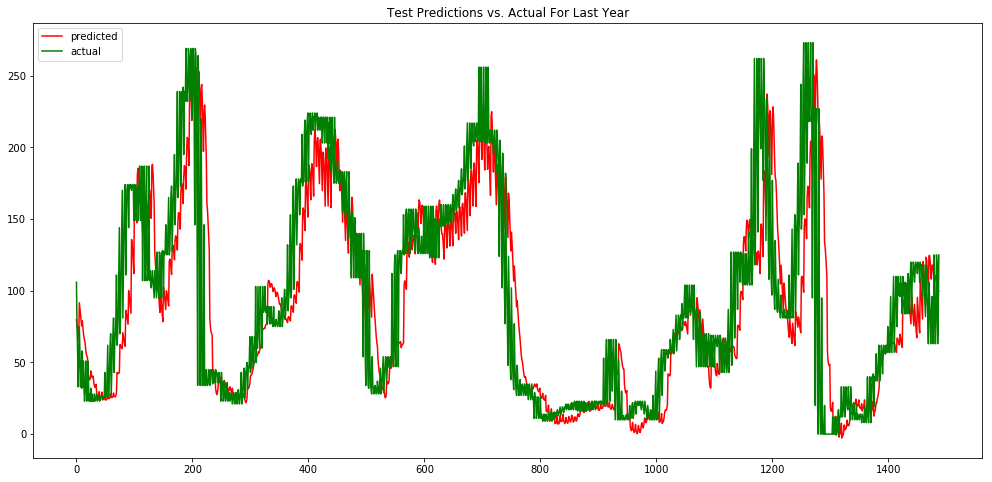

In [31]:
plot_test(unscaled_yhat.iloc[:24*31*2,], unscaled_y.iloc[:24*31*2,])